# Forecasting taxi orders

The Clear Taxi company has collected historical data on taxi orders at airports. To attract more drivers during the peak period, you need to predict the number of taxi orders for the next hour. Build a model for such a prediction.

The value of the *RMSE* metric on the test set should not exceed 48.

You need:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and draw conclusions.


The data is in the `taxi.csv` file. The number of orders is in the `num_orders` column

## Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [2]:
#loading data
try:
    df = pd.read_csv("/Users/vzuga/Documents/jupyter/datasets/taxi.csv", index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])  

df.sort_index(inplace=True)

In [3]:
#checking data
def data_check(data):
    data.info()
    print()
    display(data.head())
    print()
    print('Duplicates:', data.reset_index().duplicated().sum()) #сброс индекса для проверки явных дубликатов
    print()
    print('Missing values')
    print(data.isna().mean())   
    print()
    print('Statistics')
    print(data.describe())

In [4]:
data_check(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB



,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



Duplicates: 0

Missing values
num_orders    0.0
dtype: float64

Statistics
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000


### Conclusions:
* it is necessary to resample data for 1 hour
* there are no gaps or duplicates in the data
* check outliers in number of orders

<AxesSubplot:>

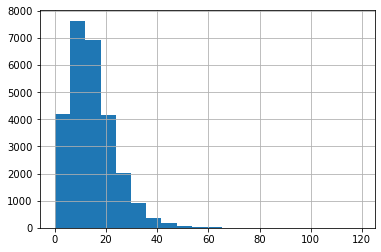

In [5]:
#distribution of the number of orders
df.num_orders.hist(bins=20)

<AxesSubplot:>

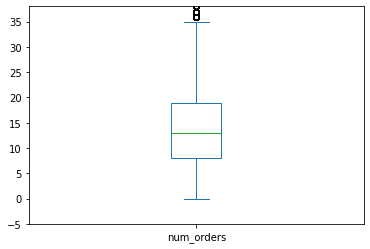

In [6]:
df.num_orders.plot(kind='box', ylim=(-5,38))

In [7]:
#number of outliers from total data
len(df.query('num_orders>35'))/len(df)

0.025928442028985508

I will remove 2% of the data with outliers in the number of orders.

In [8]:
df = df.query('num_orders<=35')

I will resample for one hour.

<AxesSubplot:title={'center':'resample'}, xlabel='datetime'>

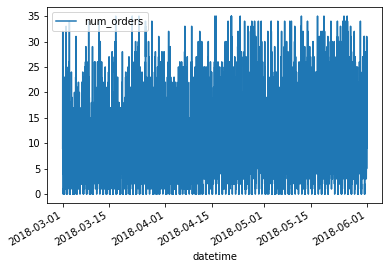

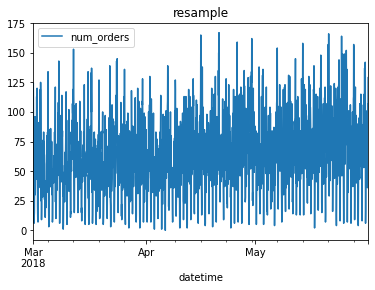

In [9]:
df['2018-03':'2018-05'].plot()
df['2018-03':'2018-05'].resample('1H').sum().plot(title='resample')

In [10]:
df = df.resample('1H').sum()

## Analysis

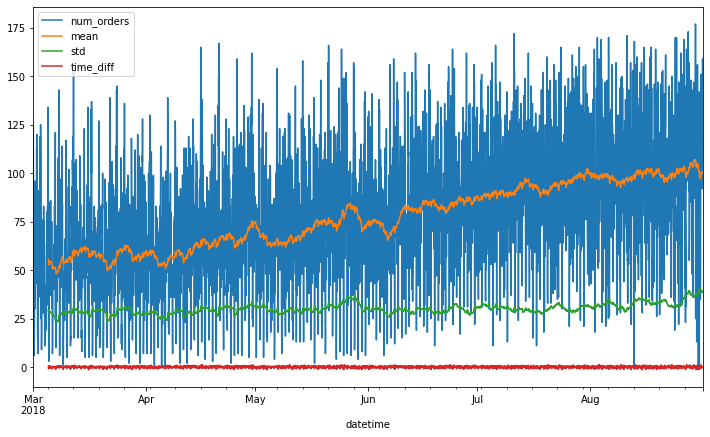

In [11]:
df['mean'] = df['num_orders'].rolling(100).mean()
df['std'] = df['num_orders'].rolling(100).std()
df['time_diff'] = df['num_orders'] - df['num_orders'].shift(fill_value=0)
df['time_diff'] = df['time_diff'].rolling(100).mean()
df.plot(figsize=(12,7))
df.drop(['mean', 'std', 'time_diff'],1, inplace=True)

The time series is not stationary - the average number of orders is growing. For further model training, I will use the time series difference.

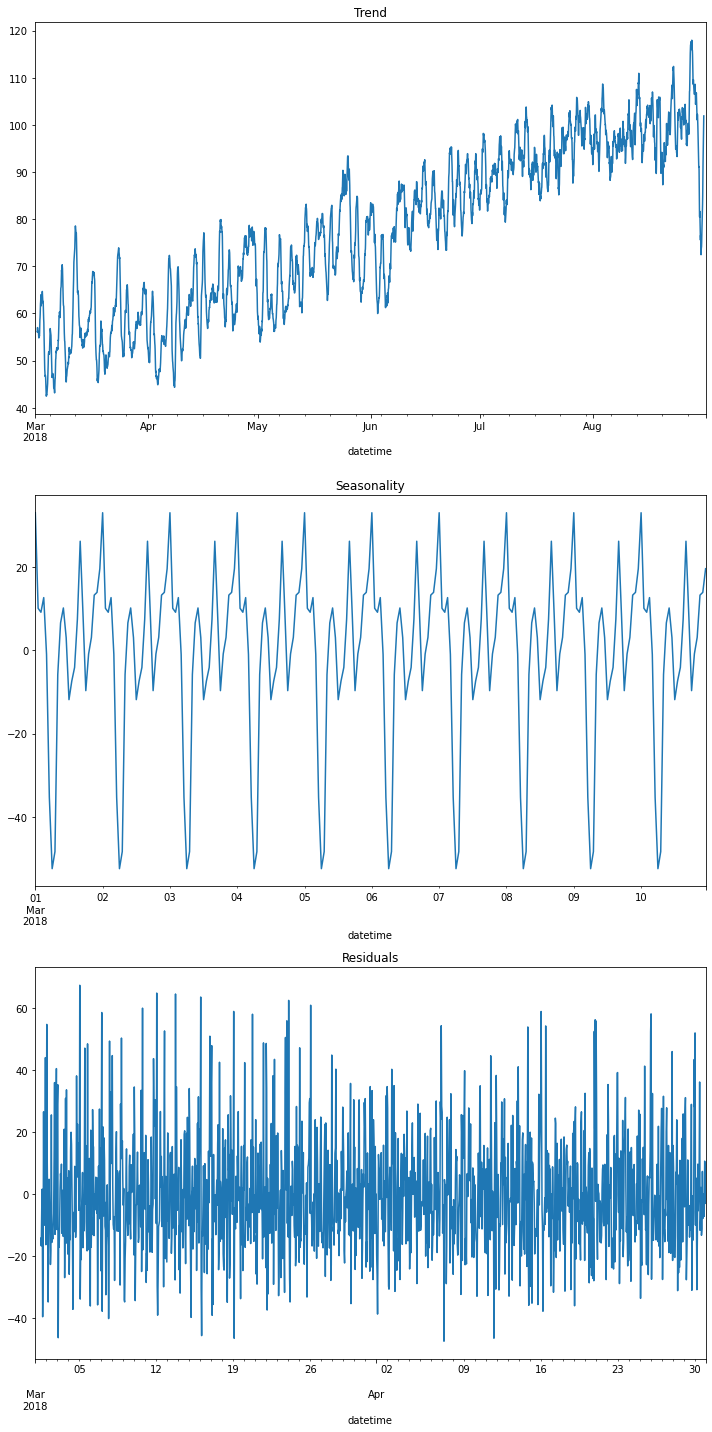

In [12]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(10, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-10'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid['2018-03':'2018-04'].plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

The data shows a trend towards an increase in the average number of orders. Since the data is only for a few months, it is impossible to answer whether this trend is related to monthly seasonality or sales growth.

The intraday seasonality is also clearly visible.

In [13]:
#function to extract features
def make_features(data_input, max_lag, rolling_mean_size):
    data = data_input.copy()
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

## Education

I will use two models: Linear regression and CatBoostRegressor.

### LinearRegression

For linear regression, I will go through different options for lagging values and rolling mean.

In [14]:
best_rmse_lr = 100
best_lag = 0
best_roll_size = 0
for lag in range(70, 75):
    for roll_size in range(5, 10):
        df_features = make_features(df, lag, roll_size)
        train, test = train_test_split(df_features, shuffle=False, test_size=0.1)
        train = train.dropna()
        features_train = train.drop(['num_orders'], 1)
        features_test = test.drop(['num_orders'], 1)
        target_train = train['num_orders']
        target_test = test['num_orders']
        model = LinearRegression()
        
        #using a scaler gave the same results
        #model = make_pipeline(StandardScaler(), LinearRegression())
        
        rmse_cv = -1*cross_val_score(model, features_train, target_train, 
                                          cv=TimeSeriesSplit(n_splits=3), scoring='neg_root_mean_squared_error')
        rmse = np.mean(rmse_cv)
        
        if rmse < best_rmse_lr:
            best_rmse_lr = rmse
            best_lag = lag
            best_roll_size = roll_size
        
print('RMSE on the training set:', int(best_rmse_lr))
print('Lag:', best_lag)
print('Rolling_mean:', best_roll_size)

RMSE on the training set: 22
Lag: 72
Rolling_mean: 8


### CatBoostRegressor

For CatBoostRegressor, I will use the selections with the parameters obtained above and iterate over the model's hyperparameters using GridSearchCV.

In [15]:
parameters = {'depth': [4,5], 'learning_rate': [0.1, 0.2], 
              'iterations':[100, 110]}
grid = GridSearchCV(estimator=CatBoostRegressor(silent=True), param_grid = parameters, 
                    cv = TimeSeriesSplit(n_splits=3), scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)
rmse_cat_train = (grid.best_score_)*-1

print('Parameters:', grid.best_params_)
print('RMSE on the training set:',int(rmse_cat_train))

Parameters: {'depth': 5, 'iterations': 110, 'learning_rate': 0.1}
RMSE on the training set: 22


## Тестирование

### LinearRegression

In [16]:
model.fit(features_train, target_train)
rmse_test_lr = mean_squared_error(target_test, model.predict(features_test), squared=False)

print('RMSE on the test sample:', rmse_test_lr)

RMSE on the test sample: 29.112263920539206


### CatBoostRegressor

In [17]:
rmse_test_cat = mean_squared_error(target_test, grid.predict(features_test), squared=False)
print('RMSE on the test sample:', rmse_test_cat)

RMSE on the test sample: 30.157812405377364


### Conclusions

,RMSE_train,RMSE_test
model,,
LinearRegression,22.983719,29.112264
CatBoost,22.354541,30.157812


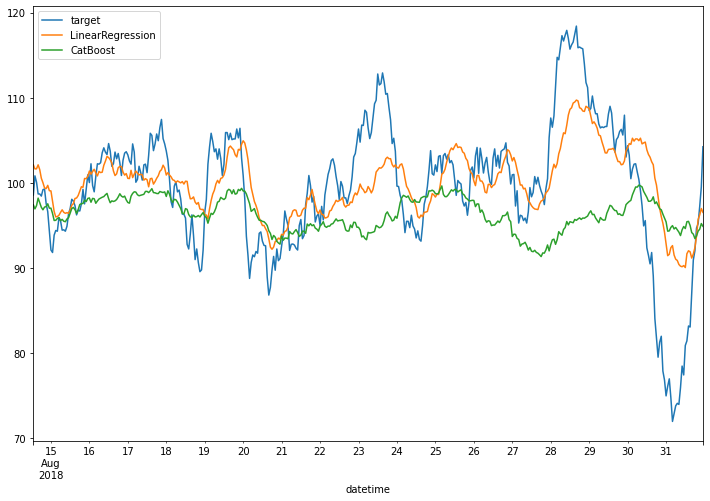

In [18]:
result = pd.DataFrame(target_test)
result["LinearRegression"] = model.predict(features_test)
result["CatBoost"] = grid.predict(features_test)
result.columns = ['target', 'LinearRegression', 'CatBoost']
result.rolling(24).mean().dropna().plot(figsize=(12,8))

models_rmse = pd.DataFrame(data={
    'model':['LinearRegression', 'CatBoost'], 'RMSE_train':[best_rmse_lr, rmse_cat_train], 
    'RMSE_test':[rmse_test_lr, rmse_test_cat]})
models_rmse.set_index(['model'])

* to predict the number of taxi orders for the next hour, two models were trained
* lagging values ​​and a rolling mean were selected for the linear regression model
* and for CatBoost - hyperparameters
* the quality of the models was tested on a test sample
* RMSE values ​​for both models on the test set are close